<a href="https://colab.research.google.com/github/gevargas/intergraphia/blob/main/intergraphia_exploring_wiki_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Influence in a Network of People**

---



This notebook provides a comprehensive workflow for analyzing a dataset of people and their connections to understand influence within the network.

**Key steps covered:**

1.  **Data Loading & Preparation:** Loading data from CSV files, standardizing columns, handling missing values, and creating a clean dataset with unique identifiers for each person.
2.  **Network Construction:** Building a graph where people are nodes, and connections (edges) are based on shared attributes (e.g., nationality).
3.  **Centrality Analysis:** Computing standard network centrality metrics (Degree, Betweenness, Closeness, PageRank) to quantify individual node importance.
4.  **Epistemic Violence Index (EVI):** Calculating a custom index (EVI) that combines node centrality with neighborhood influence to provide a nuanced measure of "epistemic power" or influence within the network.
5.  **Visualization:** Generating interactive visualizations of the network, highlighting nodes and edges based on their EVI scores.
6.  **Interactive Dashboard:** Providing an interactive dashboard to explore the network by filtering nodes and edges based on EVI and focusing on specific subgraphs.

This notebook is designed to help you identify key individuals and connections, understand the structure of influence, and explore patterns within your network data.

# **1. Setting up the environment**

1.   Importing the necessary libraries
2.   Uploading the data collections harvested from Wikipedia, partially cleaned (i.e., all elements represent people). They represent the "intellectual" community of footprint of a person of reference in Wikipedia (e.g., Gabriela Mistral)  i.e., nodes represent a people and their connections with other people in Wikipedia.
3.   Preparing the dataset that will be used for building a graph representing an intellectual community and analysing it.

**Data Preparation Workflow**


1.   Installs/imports libraries
2.   Loads your people CSVs (female + male, or a single combined file)
3.   Normalizes column names into a standard schema
4.   Deduplicates people
5.   Assigns a stable integer id to every person (this will be our node key)
6.   Saves a "clean nodes" file to data/people_nodes.csv
7.   Shows head tables + quick stats




In [99]:
!git clone 'https://github.com/gevargas/intergraphia.git'

fatal: destination path 'intergraphia' already exists and is not an empty directory.


In [100]:
# ===============================
# Step 1 — Setup & Data Ingestion
# ===============================
# Notes:
# - We read people files (female & male) OR a single all_people.csv fallback.
# - We standardize columns to: name, birth_date, birth_place, death_date, death_place, nationality, occupation, wikisite, gender
# - We deduplicate by a normalized "name" and assign a stable integer id for graph nodes.

# If you're in Colab and don't have these installed yet, uncomment:
# !pip install pandas networkx pyvis

import os
import unicodedata
import re
import pandas as pd

# ---------
# Config I/O
# ---------
os.makedirs("data", exist_ok=True)
INPUT_FEMALE = "/content/intergraphia/content/female_people.csv"   # change if your file is named differently
INPUT_MALE   = "/content/intergraphia/content/all_people.csv"     # change if your file is named differently
INPUT_ALL    = "/content/intergraphia/content/all_people.csv"      # fallback if you have a single merged file
OUTPUT_NODES = "data/people_nodes.csv"

In [101]:
# -----------------------
# Helper: normalize names
# -----------------------
def normalize_name(s) -> str:
    """Lowercase, strip accents, collapse spaces/punct — for dedup keys."""
    if not isinstance(s, str):
        s = str(s) # Convert to string if it's not
    s = s.strip().lower()
    s = "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
    s = re.sub(r"[^a-z0-9\s\-']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


In [102]:
# -----------------------------------
# Helper: standardize column mappings
# -----------------------------------
COL_MAP = {
    "name":        ["name", "Name", "label", "Person", "person"],
    "birth_date":  ["birth_date", "birthday", "birthDate", "Birth Date"],
    "death_date":  ["death_date", "deathday", "deathDate", "Death Date"],
    "nationality": ["nationality", "citizenship", "country", "Country"],
    "occupation":  ["occupation", "occupations", "Occupation"],
    "gender":      ["gender", "sex", "Gender"]
}

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame()
    for std_col, candidates in COL_MAP.items():
        for c in candidates:
            if c in df.columns:
                out[std_col] = df[c]
                break
        if std_col not in out.columns:
            out[std_col] = pd.NA
    # ensure string-ish cols are strings (not lists/objects)
    for c in ["name", "nationality", "occupation", "gender"]:
        # Replace NaN with empty strings before applying string operations
        out[c] = out[c].fillna('').astype(str).replace({"<NA>": pd.NA})
    # empty strings -> NA
    out = out.applymap(lambda x: pd.NA if (isinstance(x, str) and x.strip() == "") else x)
    return out


In [103]:
# --------------------------
# Load female/male or single
# --------------------------
dfs = []
if os.path.exists(INPUT_FEMALE) and os.path.exists(INPUT_MALE):
    print("✅ Found female_people.csv and male_people.csv — loading both.")
    dfs.append(pd.read_csv(INPUT_FEMALE))
    dfs.append(pd.read_csv(INPUT_MALE))
elif os.path.exists(INPUT_ALL):
    print("✅ Found all_people.csv — loading single combined file.")
    dfs.append(pd.read_csv(INPUT_ALL))
else:
    raise FileNotFoundError(
        "❌ No input files found. Provide either:\n"
        f" - {INPUT_FEMALE} and {INPUT_MALE}\n"
        f" - OR {INPUT_ALL}"
    )

raw = pd.concat(dfs, ignore_index=True)

✅ Found female_people.csv and male_people.csv — loading both.


In [104]:
# ---------------------------
# Standardize expected schema
# ---------------------------
std = standardize_columns(raw)

# drop rows without a name
std = std[std["name"].notna()].copy()
std["name"] = std["name"].str.strip()
std = std[std["name"] != ""]

/tmp/ipython-input-1417104113.py:27: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [105]:
# ---------------------------------
# Deduplicate by normalized name key
# ---------------------------------
std["name"] = std["name"].astype(str) # Ensure 'name' column is string type
std["name_key"] = std["name"].apply(normalize_name)
std = std.drop_duplicates(subset=["name_key"]).copy()

In [106]:
# ---------------------------
# Assign stable integer node id
# ---------------------------
std = std.reset_index(drop=True)
std.insert(0, "id", std.index.astype(int))  # id = 0..N-1

# final column order
cols = ["id","name","birth_date","death_date","nationality","occupation","gender"]
std = std[cols + ["name_key"]]  # keep name_key temporarily for QA


In [107]:
# -------------
# Save & preview
# -------------
std.to_csv(OUTPUT_NODES, index=False)
print(f"✅ Saved clean nodes file: {OUTPUT_NODES}")
print(f"👤 Total unique people: {len(std)}")

# Show a small preview
display(std.head(12)[cols])

# Quick data health checks
print("\n📊 Missing-value counts (key properties):")
display(std[["birth_date","death_date","nationality","occupation"]].isna().sum().to_frame("missing"))

# Optional: ensure Gabriela Mistral is present (by name, not required yet)
has_gabriela = std["name"].str.strip().str.lower().eq("gabriela mistral").any()
print(f"\n🧭 Gabriela Mistral present? {'Yes' if has_gabriela else 'No'}")

# Drop helper key from in-memory df (it is already saved but we keep file clean)
std = std.drop(columns=["name_key"])

✅ Saved clean nodes file: data/people_nodes.csv
👤 Total unique people: 216


,id,name,birth_date,death_date,nationality,occupation,gender
0,0,Anna Akhmatova,1889-06-23T00:00:00Z,1966-03-05T00:00:00Z,Soviet Union,writer,female
1,1,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canada,screenwriter,female
2,2,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentina,writer,female
3,3,Amanda Labarca,1886-12-05T00:00:00Z,1975-01-02T00:00:00Z,Chile,writer,female
4,4,Alejandra Costamagna,1970-03-23T00:00:00Z,NaN,Chile,writer,female
5,5,Annie Ernaux,1940-09-01T00:00:00Z,NaN,France,writer,female
6,6,Alicia Morel,1921-07-26T00:00:00Z,2017-03-01T00:00:00Z,Chile,writer,female
7,7,Andrea Thome,NaN,NaN,<NA>,<NA>,female
8,8,Aline Pettersson,1938-05-11T00:00:00Z,NaN,Mexico,writer,female
9,9,Berta Singerman,1901-09-09T00:00:00Z,1998-12-10T00:00:00Z,Argentina,actor,female



📊 Missing-value counts (key properties):


,missing
birth_date,47
death_date,86
nationality,50
occupation,46



🧭 Gabriela Mistral present? Yes


# **2. Inspect, Understand and Prepare the Dataset**

Before creating graphs or performing analysis, it is essential to explore our dataset in detail. This step helps ensure we know:

- What columns and data types are present.
- How much missing data we have for each attribute.
- Whether there are enough values in key fields like nationality, occupation, or gender for meaningful analysis.
- Basic patterns or distributions in the dataset (e.g., top nationalities represented).

By performing this check, we avoid surprises later (such as missing attributes when plotting network graphs). It also helps identify any cleaning or transformation steps we still need before analysis.

=== Dataset Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           216 non-null    int64 
 1   name         216 non-null    object
 2   birth_date   169 non-null    object
 3   death_date   130 non-null    object
 4   nationality  166 non-null    object
 5   occupation   170 non-null    object
 6   gender       173 non-null    object
dtypes: int64(1), object(6)
memory usage: 11.9+ KB

=== Descriptive Statistics (Numeric Columns) ===
            id
count  216.000
mean   107.500
std     62.498
min      0.000
25%     53.750
50%    107.500
75%    161.250
max    215.000

=== Missing Values Count ===
id              0
name            0
birth_date     47
death_date     86
nationality    50
occupation     46
gender         43
dtype: int64

=== Sample Unique Values ===
nationality: 47 unique values
nationality
Chile             27
Unit

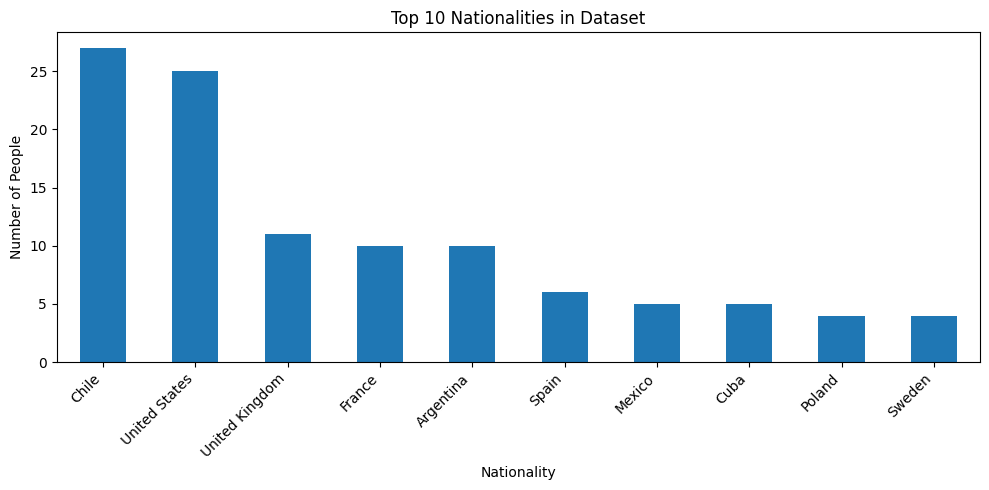

In [108]:
# STEP 1.5 — Inspect and understand the cleaned dataset
# -----------------------------------------------------

# 1. Get high-level info (columns, data types, non-null counts)
print("=== Dataset Overview ===")
std.info()

# 2. Basic descriptive stats for numeric columns (not many here, but useful if dates are numeric)
print("\n=== Descriptive Statistics (Numeric Columns) ===")
print(std.describe())

# 3. Check missing values per column
print("\n=== Missing Values Count ===")
print(std.isna().sum())

# 4. Quick look at unique values in key categorical columns
print("\n=== Sample Unique Values ===")
for col in ['nationality', 'gender', 'occupation']:
    if col in std.columns:
        print(f"{col}: {std[col].nunique()} unique values")
        print(std[col].value_counts().head(10))
        print()

# 5. Example: Count people per nationality (top 10)
nationality_counts = (
    std['nationality']
    .value_counts()
    .head(10)
)
print("\n=== Top 10 Nationalities ===")
print(nationality_counts)

# 6. Quick visual: Bar chart of top 10 nationalities
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
nationality_counts.plot(kind='bar')
plt.title("Top 10 Nationalities in Dataset")
plt.xlabel("Nationality")
plt.ylabel("Number of People")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 2.1 Load Data & Set Index

We need a clean, structured table containing all people (both male & female) with their attributes.

1. Load the CSV and set the index (id) to act as a permanent unique identifier for each row/person.

2. Result: We now have a DataFrame where:
- id = numeric unique ID (used later as graph node ID)
- Person (and other columns) = attributes linked to that ID.

In [109]:
import pandas as pd

# Step 1: Load dataset
# This CSV should contain at least:
# Person, birth_date, death_date, birth_place, death_place, nationality, occupation, wikisite
df = pd.read_csv("/content/intergraphia/content/all_people.csv")

# Step 1.1: Set index to be unique ID (row number)
df.index.name = "id"  # Name the index for clarity

# Preview first rows
df.head()


,name,birth_date,death_date,description,occupation,nationality,gender
id,,,,,,,
0,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),screenwriter,United States,male
1,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),photographer,United States,male
2,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),writer,United States,male
3,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),teacher,United States,male
4,Allen Ginsberg,1926-06-03T00:00:00Z,1997-04-05T00:00:00Z,American poet and writer (1926–1997),poet,United States,male


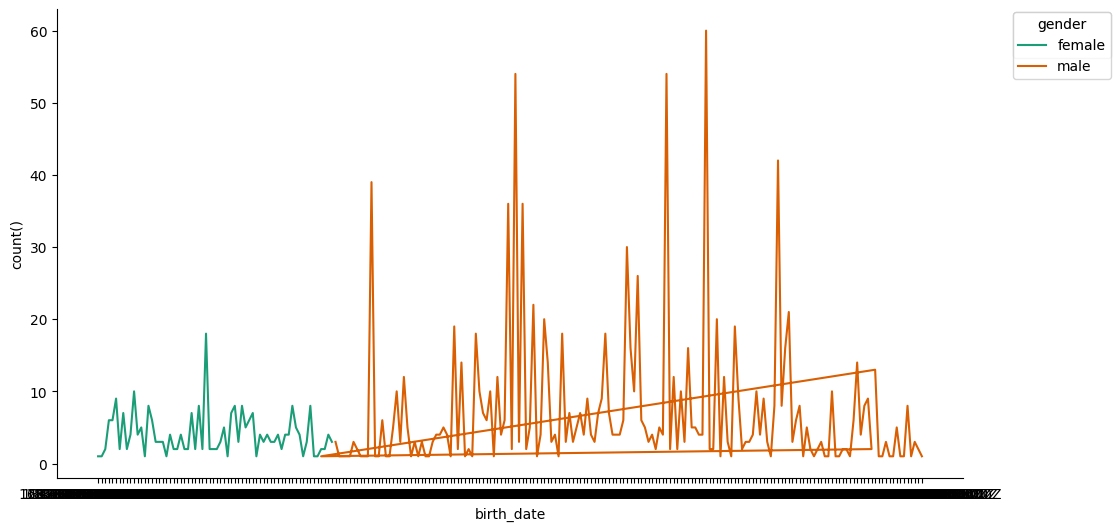

In [110]:
# @title birth_date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['birth_date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'birth_date'}, axis=1)
              .sort_values('birth_date', ascending=True))
  xs = counted['birth_date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birth_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birth_date')
_ = plt.ylabel('count()')

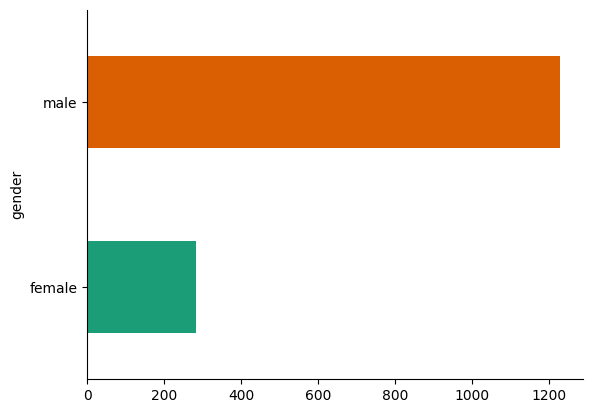

In [111]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

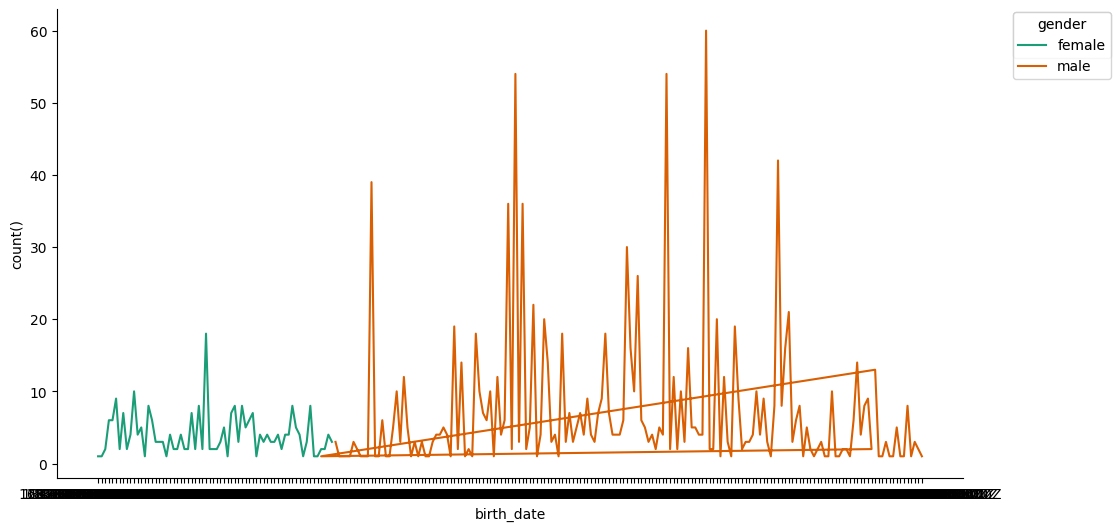

In [112]:
# @title birth_date vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['birth_date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'birth_date'}, axis=1)
              .sort_values('birth_date', ascending=True))
  xs = counted['birth_date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('birth_date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('birth_date')
_ = plt.ylabel('count()')

## 2.2 Inspect Data Structure and Content

Before cleaning or analysing, we must know what is inside the data collection — data types, missing values, and column structures.

- .info() → shows number of non-null entries, column types, memory usage.

- .describe() → shows summary statistics; with include="all" it includes object (string) columns too.

In [113]:
# Step 1.5: Inspect data types, missing values, and size
df.info()

# Quick statistical/structural overview
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         2226 non-null   object
 1   birth_date   1470 non-null   object
 2   death_date   1237 non-null   object
 3   description  2064 non-null   object
 4   occupation   1487 non-null   object
 5   nationality  1445 non-null   object
 6   gender       1510 non-null   object
dtypes: object(7)
memory usage: 121.9+ KB


,name,birth_date,death_date,description,occupation,nationality,gender
count,2226,1470,1237,2064,1487,1445,1510
unique,216,231,168,771,193,81,2
top,Buenos Aires,1918-12-11T00:00:00Z,2008-08-03T00:00:00Z,"Russian writer, publicist, poet and politician...",writer,United States,male
freq,162,60,60,60,188,149,1227


### 2.2.1 Cleaning Data: missing values, duplicates and assessing dataset quality

In [114]:
# Step 2.1: Handle missing values
# For text columns, replace NaN with empty string
text_columns = ['name', 'nationality', 'occupation',]
df[text_columns] = df[text_columns].fillna("")

# For date columns, leave NaN as is but make sure they are datetime objects
date_columns = ['birth_date', 'death_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 2.2: Remove duplicate rows based on Person name (if any)
df = df.drop_duplicates(subset=['name'], keep='first')

# Step 2.3: Re-check data after cleaning
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 216 entries, 0 to 2193
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   name         216 non-null    object             
 1   birth_date   168 non-null    datetime64[ns, UTC]
 2   death_date   129 non-null    datetime64[ns, UTC]
 3   description  210 non-null    object             
 4   occupation   216 non-null    object             
 5   nationality  216 non-null    object             
 6   gender       171 non-null    object             
dtypes: datetime64[ns, UTC](2), object(5)
memory usage: 13.5+ KB


,name,birth_date,death_date,description,occupation,nationality,gender
id,,,,,,,
0,Allen Ginsberg,1926-06-03 00:00:00+00:00,1997-04-05 00:00:00+00:00,American poet and writer (1926–1997),screenwriter,United States,male
9,Aleksandr Solzhenitsyn,1918-12-11 00:00:00+00:00,2008-08-03 00:00:00+00:00,"Russian writer, publicist, poet and politician...",screenwriter,Russia,male
69,Albert Camus,1913-11-07 00:00:00+00:00,1960-01-04 00:00:00+00:00,"French philosopher, author, and journalist (19...",writer,France,male
79,Alexander Fleming,1881-08-06 00:00:00+00:00,1955-03-11 00:00:00+00:00,"Scottish biologist, pharmacologist, botanist, ...",physician,United Kingdom,male
84,Anatole France,1844-04-16 00:00:00+00:00,1924-10-12 00:00:00+00:00,French writer (1844–1924),writer,France,male


### 2.2.2 Transform Data

We transform raw fields into more usable and meaningful formats.

- birth_year / death_year → Makes time-based analysis easier.
- lifespan_years → Useful for demographic stats.
- occupation_list → Turns one string into a structured Python list.
- info_summary → Compact profile text to display in graph tooltips.

In [115]:
# Step 3.1: Extract birth year and death year
df['birth_year'] = df['birth_date'].dt.year
df['death_year'] = df['death_date'].dt.year

# Step 3.2: Calculate lifespan (if death date is available)
df['lifespan_years'] = df.apply(
    lambda row: (row['death_year'] - row['birth_year'])
    if pd.notnull(row['death_year']) and pd.notnull(row['birth_year']) else None,
    axis=1
)

# Step 3.3: Standardize occupations list (split on commas, trim spaces)
df['occupation_list'] = df['occupation'].apply(
    lambda x: [occ.strip() for occ in x.split(',')] if x else []
)

# Step 3.4: Create a short info summary (for tooltips in the graph later)
df['info_summary'] = df.apply(
    lambda row: f"{row['name']} — {row['birth_year']} to {row['death_year'] if row['death_year'] else 'Present'}, " +
                f"Occupation: {', '.join(row['occupation_list']) if row['occupation_list'] else 'N/A'}, " +
                f"Nationality: {row['nationality'] if row['nationality'] else 'N/A'}",
    axis=1
)

# Step 3.5: Preview transformed data
df.head()

,name,birth_date,death_date,description,occupation,nationality,gender,birth_year,death_year,lifespan_years,occupation_list,info_summary
id,,,,,,,,,,,,
0,Allen Ginsberg,1926-06-03 00:00:00+00:00,1997-04-05 00:00:00+00:00,American poet and writer (1926–1997),screenwriter,United States,male,1926.0,1997.0,71.0,[screenwriter],"Allen Ginsberg — 1926.0 to 1997.0, Occupation:..."
9,Aleksandr Solzhenitsyn,1918-12-11 00:00:00+00:00,2008-08-03 00:00:00+00:00,"Russian writer, publicist, poet and politician...",screenwriter,Russia,male,1918.0,2008.0,90.0,[screenwriter],"Aleksandr Solzhenitsyn — 1918.0 to 2008.0, Occ..."
69,Albert Camus,1913-11-07 00:00:00+00:00,1960-01-04 00:00:00+00:00,"French philosopher, author, and journalist (19...",writer,France,male,1913.0,1960.0,47.0,[writer],"Albert Camus — 1913.0 to 1960.0, Occupation: w..."
79,Alexander Fleming,1881-08-06 00:00:00+00:00,1955-03-11 00:00:00+00:00,"Scottish biologist, pharmacologist, botanist, ...",physician,United Kingdom,male,1881.0,1955.0,74.0,[physician],"Alexander Fleming — 1881.0 to 1955.0, Occupati..."
84,Anatole France,1844-04-16 00:00:00+00:00,1924-10-12 00:00:00+00:00,French writer (1844–1924),writer,France,male,1844.0,1924.0,80.0,[writer],"Anatole France — 1844.0 to 1924.0, Occupation:..."


### 2.2.3 Exploring Data

This step helps us understand the overall structure and quality of the dataset before building graphs.

- Total people → Size of dataset.
- Missing data counts → Data quality check.
- Top nationalities → Cultural/geographic spread.
- Top occupations → Common professions in the dataset.
- Lifespan stats → Demographic insights.
- Gabriela Mistral profile → Specific focus node for our project.

In [116]:
# Step 4.1: Basic dataset statistics
total_people = len(df)
missing_birthdates = df['birth_date'].isna().sum()
missing_deathdates = df['death_date'].isna().sum()

print(f"Total people in dataset: {total_people}")
print(f"Missing birth dates: {missing_birthdates}")
print(f"Missing death dates: {missing_deathdates}")

# Step 4.2: Top 10 nationalities
top_nationalities = df['nationality'].value_counts().head(10)
print("\nTop 10 nationalities:")
print(top_nationalities)

# Step 4.3: Most common occupations
from collections import Counter

all_occupations = [occ for sublist in df['occupation_list'] for occ in sublist]
occupation_counts = Counter(all_occupations).most_common(10)
print("\nTop 10 occupations:")
for occ, count in occupation_counts:
    print(f"{occ}: {count}")

# Step 4.4: Lifespan statistics (ignoring missing values)
avg_lifespan = df['lifespan_years'].dropna().mean()
max_lifespan = df['lifespan_years'].dropna().max()

print(f"\nAverage lifespan: {avg_lifespan:.1f} years")
print(f"Maximum lifespan: {max_lifespan} years")

# Step 4.5: Specific analysis — Gabriela Mistral
gm_data = df[df['name'] == "Gabriela Mistral"]
if not gm_data.empty:
    print("\nGabriela Mistral's Profile:")
    display(gm_data)
else:
    print("\nGabriela Mistral not found in dataset!")

Total people in dataset: 216
Missing birth dates: 48
Missing death dates: 87

Top 10 nationalities:
nationality
                  51
Chile             27
United States     25
United Kingdom    11
France            10
Argentina         10
Spain              6
Mexico             5
Cuba               5
Sweden             4
Name: count, dtype: int64

Top 10 occupations:
writer: 88
screenwriter: 34
composer: 10
actor: 8
lawyer: 4
poet: 4
physician: 2
painter: 2
teacher: 2
inventor: 1

Average lifespan: 77.1 years
Maximum lifespan: 104.0 years

Gabriela Mistral's Profile:


,name,birth_date,death_date,description,occupation,nationality,gender,birth_year,death_year,lifespan_years,occupation_list,info_summary
id,,,,,,,,,,,,
656,Gabriela Mistral,1889-04-07 00:00:00+00:00,1957-01-10 00:00:00+00:00,"Chilean poet, diplomat and educator (1889–1957)",writer,Chile,female,1889.0,1957.0,68.0,[writer],"Gabriela Mistral — 1889.0 to 1957.0, Occupatio..."


# **3. Building a Graph Mesh**

In [117]:
!pip install pyvis networkx pandas

In [118]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
from IPython.core.display import display, HTML

# === Load dataset ===
df = pd.read_csv("/content/intergraphia/content/all_people.csv")  # Replace with your CSV path

# === 1. Create Graph ===
G = nx.Graph()

for _, row in df.iterrows():
    G.add_node(
        row['name'],
        birth_date=row.get('birth_date'),
        death_date=row.get('death_date'),
        nationality=row.get('nationality'),
        occupations=", ".join(row['occupation_list']) if isinstance(row.get('occupation_list'), list) else row.get('occupation'),
        description=row.get('description'),
        wikisite=row.get('wikisite')
    )

# === 2. Create edges (example: same nationality) ===
for nat in df['nationality'].dropna().unique():
    same_nat_people = df[df['nationality'] == nat]['name'].tolist()
    for i in range(len(same_nat_people)):
        for j in range(i+1, len(same_nat_people)):
            G.add_edge(same_nat_people[i], same_nat_people[j])

# === 3. Gabriela Mistral subgraph stats ===
if "Gabriela Mistral" in G.nodes:
    gm_neighbors = list(nx.neighbors(G, "Gabriela Mistral"))
    gm_subgraph = G.subgraph(["Gabriela Mistral"] + gm_neighbors)
    print("Gabriela Mistral Mesh Graph Stats:")
    print(f"Nodes: {gm_subgraph.number_of_nodes()}")
    print(f"Edges: {gm_subgraph.number_of_edges()}")
else:
    print("Gabriela Mistral not found.")

# === 4. Visualize inline ===
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

for node, data in G.nodes(data=True):
    title_info = "<br>".join([f"{k}: {v}" for k, v in data.items() if v])
    net.add_node(node, label=node, title=title_info)

for source, target in G.edges():
    net.add_edge(source, target)

# Save & display inline
net.save_graph("mesh_graph.html")
display(HTML("mesh_graph.html"))


Gabriela Mistral Mesh Graph Stats:
Nodes: 29
Edges: 428


## 3.1 Exploratory Data Analysis (EDA)
Using a Data Analysis Helper Library
pandas-profiling (now ydata-profiling)

In [119]:
# ===============================
# Step 1 — Setup & Data Ingestion
# ===============================
# Notes:
# - We read people files (female & male) OR a single all_people.csv fallback.
# - We standardize columns to: name, birth_date, birth_place, death_date, death_place, nationality, occupation, wikisite, gender
# - We deduplicate by a normalized "name" and assign a stable integer id for graph nodes.

# If you're in Colab and don't have these installed yet, uncomment:
# !pip install pandas networkx pyvis

import os
import unicodedata
import re
import pandas as pd

# ---------
# Config I/O
# ---------
os.makedirs("data", exist_ok=True)
INPUT_FEMALE = "/content/intergraphia/content/female_people.csv"   # change if your file is named differently
INPUT_MALE   = "/content/intergraphia/content/all_people.csv"     # change if your file is named differently
INPUT_ALL    = "/content/intergraphia/content/all_people.csv"      # fallback if you have a single merged file
OUTPUT_NODES = "data/people_nodes.csv"

# -----------------------
# Helper: normalize names
# -----------------------
def normalize_name(s) -> str:
    """Lowercase, strip accents, collapse spaces/punct — for dedup keys."""
    if not isinstance(s, str):
        s = str(s) # Convert to string if it's not
    s = s.strip().lower()
    s = "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
    s = re.sub(r"[^a-z0-9\s\-']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# -----------------------------------
# Helper: standardize column mappings
# -----------------------------------
COL_MAP = {
    "name":        ["name", "Name", "label", "Person", "person"],
    "birth_date":  ["birth_date", "birthday", "birthDate", "Birth Date"],
    "death_date":  ["death_date", "deathday", "deathDate", "Death Date"],
    "nationality": ["nationality", "citizenship", "country", "Country"],
    "occupation":  ["occupation", "occupations", "Occupation"],
    "gender":      ["gender", "sex", "Gender"]
}

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame()
    for std_col, candidates in COL_MAP.items():
        for c in candidates:
            if c in df.columns:
                out[std_col] = df[c]
                break
        if std_col not in out.columns:
            out[std_col] = pd.NA
    # ensure string-ish cols are strings (not lists/objects)
    for c in ["name", "nationality", "occupation", "gender"]:
        # Replace NaN with empty strings before applying string operations
        out[c] = out[c].fillna('').astype(str).replace({"<NA>": pd.NA})
    # empty strings -> NA
    out = out.applymap(lambda x: pd.NA if (isinstance(x, str) and x.strip() == "") else x)
    return out

# --------------------------
# Load female/male or single
# --------------------------
dfs = []
if os.path.exists(INPUT_FEMALE) and os.path.exists(INPUT_MALE):
    print("✅ Found female_people.csv and male_people.csv — loading both.")
    dfs.append(pd.read_csv(INPUT_FEMALE))
    dfs.append(pd.read_csv(INPUT_MALE))
elif os.path.exists(INPUT_ALL):
    print("✅ Found all_people.csv — loading single combined file.")
    dfs.append(pd.read_csv(INPUT_ALL))
else:
    raise FileNotFoundError(
        "❌ No input files found. Provide either:\n"
        f" - {INPUT_FEMALE} and {INPUT_MALE}\n"
        f" - OR {INPUT_ALL}"
    )

raw = pd.concat(dfs, ignore_index=True)

# ---------------------------
# Standardize expected schema
# ---------------------------
std = standardize_columns(raw)

# drop rows without a name
std = std[std["name"].notna()].copy()
std["name"] = std["name"].str.strip()
std = std[std["name"] != ""]

# ---------------------------------
# Deduplicate by normalized name key
# ---------------------------------
std["name"] = std["name"].astype(str) # Ensure 'name' column is string type
std["name_key"] = std["name"].apply(normalize_name)
std = std.drop_duplicates(subset=["name_key"]).copy()

# ---------------------------
# Assign stable integer node id
# ---------------------------
std = std.reset_index(drop=True)
std.insert(0, "id", std.index.astype(int))  # id = 0..N-1

# final column order
cols = ["id","name","birth_date","death_date","nationality","occupation","gender"]
std = std[cols + ["name_key"]]  # keep name_key temporarily for QA

# -------------
# Save & preview
# -------------
std.to_csv(OUTPUT_NODES, index=False)
print(f"✅ Saved clean nodes file: {OUTPUT_NODES}")
print(f"👤 Total unique people: {len(std)}")

# Show a small preview
display(std.head(12)[cols])

# Quick data health checks
print("\n📊 Missing-value counts (key properties):")
display(std[["birth_date","death_date","nationality","occupation"]].isna().sum().to_frame("missing"))

# Optional: ensure Gabriela Mistral is present (by name, not required yet)
has_gabriela = std["name"].str.strip().str.lower().eq("gabriela mistral").any()
print(f"\n🧭 Gabriela Mistral present? {'Yes' if has_gabriela else 'No'}")

# Drop helper key from in-memory df (it is already saved but we keep file clean)
std = std.drop(columns=["name_key"])

!pip install ydata-profiling

from ydata_profiling import ProfileReport

profile = ProfileReport(std, explorative=True)
profile.to_notebook_iframe()

✅ Found female_people.csv and male_people.csv — loading both.
✅ Saved clean nodes file: data/people_nodes.csv
👤 Total unique people: 216


/tmp/ipython-input-3854248233.py:65: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,id,name,birth_date,death_date,nationality,occupation,gender
0,0,Anna Akhmatova,1889-06-23T00:00:00Z,1966-03-05T00:00:00Z,Soviet Union,writer,female
1,1,Alice Munro,1931-07-10T00:00:00Z,2024-05-13T00:00:00Z,Canada,screenwriter,female
2,2,Alfonsina Storni,1892-05-29T00:00:00Z,1938-10-25T00:00:00Z,Argentina,writer,female
3,3,Amanda Labarca,1886-12-05T00:00:00Z,1975-01-02T00:00:00Z,Chile,writer,female
4,4,Alejandra Costamagna,1970-03-23T00:00:00Z,NaN,Chile,writer,female
5,5,Annie Ernaux,1940-09-01T00:00:00Z,NaN,France,writer,female
6,6,Alicia Morel,1921-07-26T00:00:00Z,2017-03-01T00:00:00Z,Chile,writer,female
7,7,Andrea Thome,NaN,NaN,<NA>,<NA>,female
8,8,Aline Pettersson,1938-05-11T00:00:00Z,NaN,Mexico,writer,female
9,9,Berta Singerman,1901-09-09T00:00:00Z,1998-12-10T00:00:00Z,Argentina,actor,female



📊 Missing-value counts (key properties):


,missing
birth_date,47
death_date,86
nationality,50
occupation,46



🧭 Gabriela Mistral present? Yes


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 31.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3.2 Computing Node Centrality Metrics

The **objective** is to quantify a node’s influence and connectivity within the network.

We calculate fundamental centrality metrics for each node in the graph:

- Degree Centrality — number of direct connections a node has.
- Betweenness Centrality — how often a node lies on the shortest paths between other nodes.
- Closeness Centrality — how close a node is to all other nodes in the graph.
- PageRank — importance of a node based on connections’ importance.

We will then add these metrics as node attributes in the graph G.

***Interpretation***

- A node with high betweenness might act as a “bridge” between communities.
- A node with high-degree connects many people.
- PageRank identifies globally important nodes.

*After this step:*

- Each node in G will have attributes: degree, betweenness, closeness, and pagerank.

 These values are useful to compute the Epistemic Violence Index or visualise  influential nodes.

In [122]:
import networkx as nx
import pandas as pd # Import pandas to load the data

# Load dataset
# This CSV should contain at least:
# Person, birth_date, death_date, birth_place, death_place, nationality, occupation, wikisite
df = pd.read_csv("/content/intergraphia/content/all_people.csv")  # Replace with your CSV path

# === 1. Create Graph ===
G = nx.Graph()

for _, row in df.iterrows():
    # Ensure 'occupation_list' is a list, splitting if necessary
    occupations_data = row.get('occupation')
    occupation_list = [occ.strip() for occ in str(occupations_data).split(',')] if pd.notna(occupations_data) else []

    G.add_node(
        row['name'],
        birth_date=row.get('birth_date'),
        death_date=row.get('death_date'),
        nationality=row.get('nationality'),
        occupations=", ".join(occupation_list), # Use the processed list for the node attribute
        description=row.get('description'),
        wikisite=row.get('wikisite'),
        occupation_list=occupation_list # Keep the list for similarity bonus calculation later
    )

# === 2. Create edges (example: same nationality) ===
# Filter out NaN nationalities before iterating
for nat in df['nationality'].dropna().unique():
    # Ensure 'name' column is treated as string before filtering
    same_nat_people = df[df['nationality'] == nat]['name'].astype(str).tolist()
    for i in range(len(same_nat_people)):
        for j in range(i+1, len(same_nat_people)):
            # Check if nodes exist in the graph before adding edge
            if same_nat_people[i] in G.nodes and same_nat_people[j] in G.nodes:
                 G.add_edge(same_nat_people[i], same_nat_people[j])


# 1. Degree centrality
degree_centrality = nx.degree_centrality(G)

# 2. Betweenness centrality (approximation for large graphs)
# Set k to a sample of nodes for efficiency if the graph is huge
# Removed k as the graph is not large enough to require sampling and k was larger than the number of nodes
betweenness_centrality = nx.betweenness_centrality(G, seed=42) # Removed k=500

# 3. Closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# 4. PageRank
pagerank = nx.pagerank(G)

# 5. Tag nodes with metrics
for node in G.nodes:
    G.nodes[node]['degree'] = degree_centrality[node]
    G.nodes[node]['betweenness'] = betweenness_centrality[node]
    G.nodes[node]['closeness'] = closeness_centrality[node]
    G.nodes[node]['pagerank'] = pagerank[node]

print("✅ Node centrality metrics computed and tagged.")

✅ Node centrality metrics computed and tagged.


In [123]:
for node, data in list(G.nodes(data=True))[:5]:
    print(f"{node}: {data}")


Allen Ginsberg: {'birth_date': nan, 'death_date': nan, 'nationality': nan, 'occupations': '', 'description': 'Ph.D. Rutgers University, New Brunswick 1986', 'wikisite': None, 'occupation_list': [], 'degree': 0.13488372093023254, 'betweenness': 0.0, 'closeness': 0.31046950416849495, 'pagerank': 0.007167203050236397}
Aleksandr Solzhenitsyn: {'birth_date': '1918-12-11T00:00:00Z', 'death_date': '2008-08-03T00:00:00Z', 'nationality': 'Russian Socialist Federative Soviet Republic', 'occupations': 'militant', 'description': 'Russian writer, publicist, poet and politician (1918–2008)', 'wikisite': None, 'occupation_list': ['militant'], 'degree': 0.037209302325581395, 'betweenness': 0.0, 'closeness': 0.22116779194798702, 'pagerank': 0.0033766632786960357}
Albert Camus: {'birth_date': nan, 'death_date': nan, 'nationality': nan, 'occupations': '', 'description': '1973 film', 'wikisite': None, 'occupation_list': [], 'degree': 0.05581395348837209, 'betweenness': 0.0, 'closeness': 0.1949630772622065

In [124]:
import pandas as pd

# Collect first 10 nodes and their metrics
nodes_data = []
for node, data in list(G.nodes(data=True))[:10]:
    nodes_data.append({
        'name': node,
        'degree': round(data.get('degree', 0), 4),
        'betweenness': round(data.get('betweenness', 0), 4),
        'closeness': round(data.get('closeness', 0), 4),
        'pagerank': round(data.get('pagerank', 0), 4)
    })

# Create a DataFrame for nice display
df_metrics = pd.DataFrame(nodes_data)
display(df_metrics)


,name,degree,betweenness,closeness,pagerank
0,Allen Ginsberg,0.1349,0.0000,0.3105,0.0072
1,Aleksandr Solzhenitsyn,0.0372,0.0000,0.2212,0.0034
2,Albert Camus,0.0558,0.0000,0.1950,0.0055
3,Alexander Fleming,0.0698,0.0000,0.2371,0.0051
4,Anatole France,0.0558,0.0000,0.1950,0.0055
5,Anna Akhmatova,0.0512,0.0018,0.2532,0.0042
6,Artturi Ilmari Virtanen,0.0093,0.0000,0.0000,0.0056
7,Alice Munro,0.0093,0.0000,0.0000,0.0056
8,Alfonsina Storni,0.0605,0.0000,0.2212,0.0050
9,Abdulrazak Gurnah,0.0698,0.0000,0.2371,0.0051


from matplotlib import pyplot as plt
df_metrics['degree'].plot(kind='hist', bins=20, title='degree')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['betweenness'].plot(kind='hist', bins=20, title='betweenness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['closeness'].plot(kind='hist', bins=20, title='closeness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['pagerank'].plot(kind='hist', bins=20, title='pagerank')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='degree', y='betweenness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='betweenness', y='closeness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics.plot(kind='scatter', x='closeness', y='pagerank', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['degree'].plot(kind='line', figsize=(8, 4), title='degree')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['betweenness'].plot(kind='line', figsize=(8, 4), title='betweenness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['closeness'].plot(kind='line', figsize=(8, 4), title='closeness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_metrics['pagerank'].plot(kind='line', figsize=(8, 4), title='pagerank')
plt.gca().spines[['top', 'right']].set_visible(False)

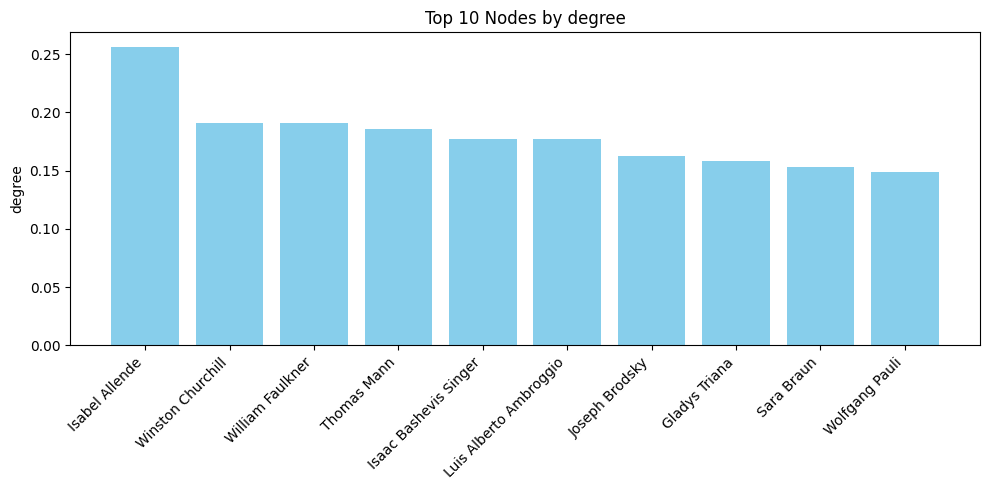

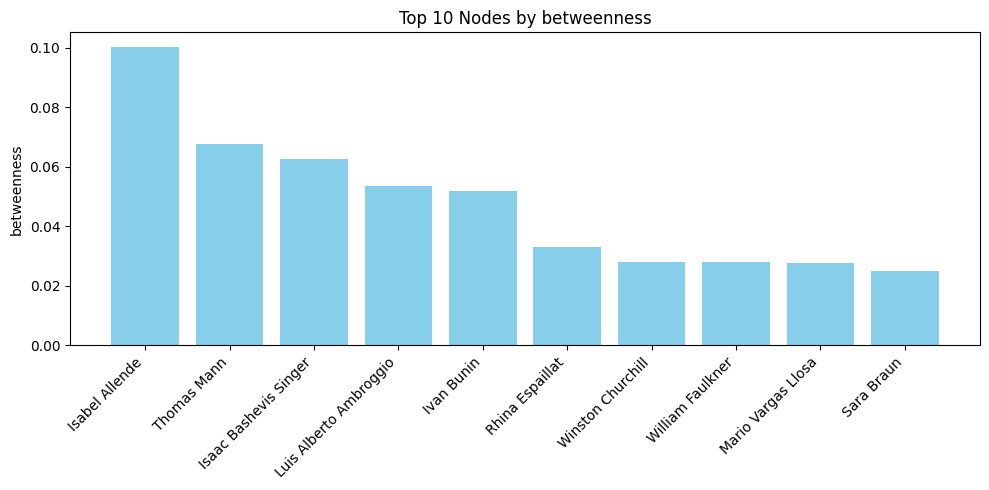

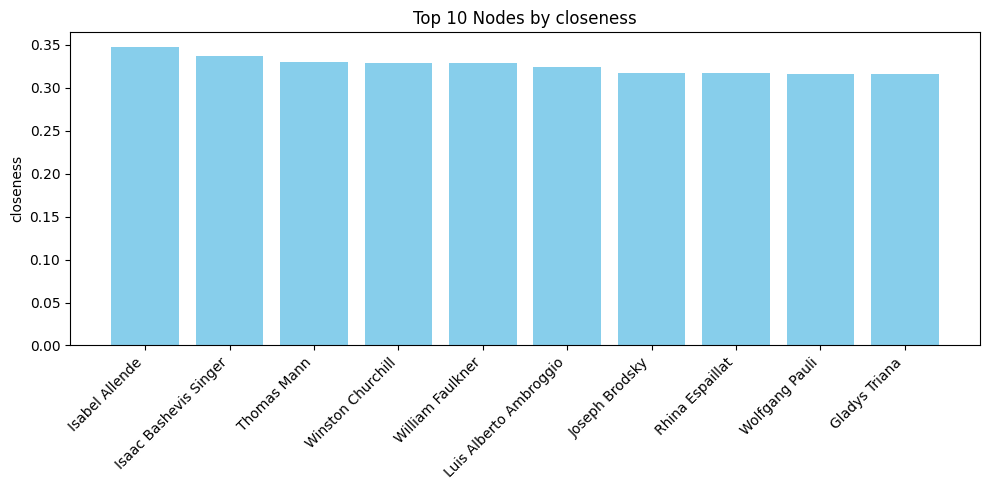

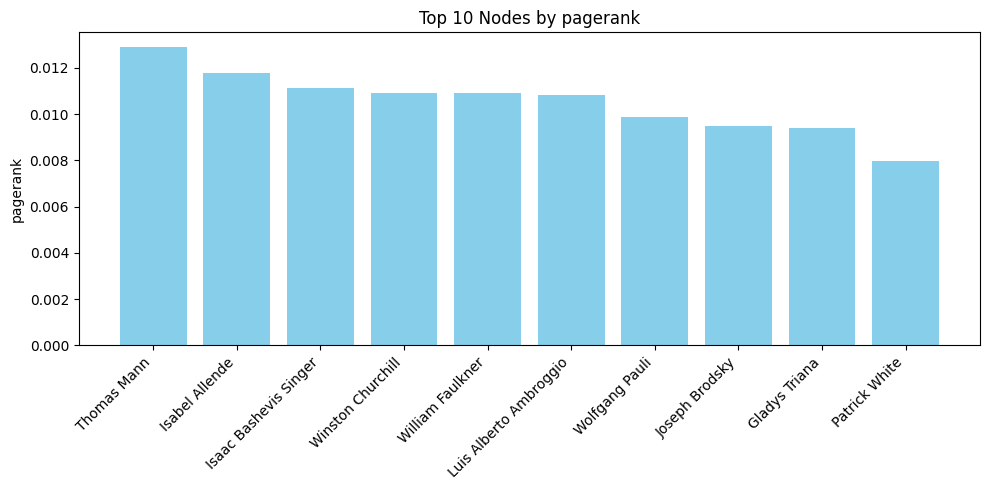

In [125]:
import matplotlib.pyplot as plt

# Convert node metrics to DataFrame
all_nodes_data = []
for node, data in G.nodes(data=True):
    all_nodes_data.append({
        'name': node,
        'degree': data.get('degree', 0),
        'betweenness': data.get('betweenness', 0),
        'closeness': data.get('closeness', 0),
        'pagerank': data.get('pagerank', 0)
    })

df_all_metrics = pd.DataFrame(all_nodes_data)

# Function to plot top N nodes by a metric
def plot_top_metric(df, metric, top_n=10):
    df_top = df.sort_values(metric, ascending=False).head(top_n)
    plt.figure(figsize=(10,5))
    plt.bar(df_top['name'], df_top[metric], color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.title(f"Top {top_n} Nodes by {metric}")
    plt.tight_layout()
    plt.show()

# Plot top nodes for each metric
for metric in ['degree', 'betweenness', 'closeness', 'pagerank']:
    plot_top_metric(df_all_metrics, metric)


# **4. Computing Epistemic Violence Index (EVI)**


The EVI is a measure of influence or “epistemic power” of each node in the network, based on:

Node metrics (degree, betweenness, closeness, PageRank).

Neighborhood influence: average metrics of directly connected neighbors.

Hop limit: only consider neighbors up to a certain depth (e.g., 1 or 2 hops) to prevent combinatorial explosion on large graphs.

**Why?**

- Nodes are not just important by themselves—they can also gain influence from connected nodes.

- Limiting hops keeps computation scalable even for very large graphs.

- Combining metrics into a single index gives a comprehensive view of influence in the network.

In [126]:
def compute_evi(G, alpha=0.4, beta=0.4, gamma=0.2, hop_limit=1):
    """
    Compute Epistemic Violence Index (EVI) for each node.

    EVI = alpha * degree + beta * pagerank + gamma * avg_neighbor_betweenness

    hop_limit: number of hops to consider for neighbors
    """
    for node in G.nodes:
        # Node metrics
        degree = G.nodes[node].get('degree', 0)
        pagerank = G.nodes[node].get('pagerank', 0)

        # Neighborhood influence
        # Collect neighbors up to hop_limit
        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=hop_limit).keys()
        neighbors = [n for n in neighbors if n != node]  # exclude self

        if neighbors:
            avg_neighbor_betweenness = sum(G.nodes[n].get('betweenness', 0) for n in neighbors) / len(neighbors)
        else:
            avg_neighbor_betweenness = 0

        # Compute EVI
        G.nodes[node]['EVI'] = alpha * degree + beta * pagerank + gamma * avg_neighbor_betweenness

    print("✅ Epistemic Violence Index (EVI) computed for all nodes.")


In [127]:

compute_evi(G, alpha=0.4, beta=0.4, gamma=0.2, hop_limit=1)


✅ Epistemic Violence Index (EVI) computed for all nodes.


In [128]:
# Show top 10 nodes by EVI
top_evi = sorted(G.nodes(data=True), key=lambda x: x[1].get('EVI',0), reverse=True)[:10]

for node, data in top_evi:
    print(f"{node}: EVI={data['EVI']:.4f}, degree={data['degree']:.4f}, pagerank={data['pagerank']:.4f}, betweenness={data['betweenness']:.4f}")


Isabel Allende: EVI=0.1084, degree=0.2558, pagerank=0.0118, betweenness=0.1002
Winston Churchill: EVI=0.0829, degree=0.1907, pagerank=0.0109, betweenness=0.0281
William Faulkner: EVI=0.0829, degree=0.1907, pagerank=0.0109, betweenness=0.0281
Thomas Mann: EVI=0.0818, degree=0.1860, pagerank=0.0129, betweenness=0.0676
Isaac Bashevis Singer: EVI=0.0777, degree=0.1767, pagerank=0.0111, betweenness=0.0627
Luis Alberto Ambroggio: EVI=0.0771, degree=0.1767, pagerank=0.0108, betweenness=0.0536
Joseph Brodsky: EVI=0.0715, degree=0.1628, pagerank=0.0095, betweenness=0.0167
Gladys Triana: EVI=0.0697, degree=0.1581, pagerank=0.0094, betweenness=0.0230
Wolfgang Pauli: EVI=0.0661, degree=0.1488, pagerank=0.0099, betweenness=0.0237
Sara Braun: EVI=0.0657, degree=0.1535, pagerank=0.0073, betweenness=0.0251


## 4.1 Tagging the Graph Mesh Nodes with EVI
***What we are doing?***
- Use PyVis for interactive visualization.
- Node size will reflect the EVI: higher EVI → larger node.
- Node color will also reflect EVI, giving an intuitive heatmap of influence.
- Tooltip will show node metrics and EVI for each node.

***Why?***
1. Visualising EVI directly shows which nodes are most influential.
2. Interactive PyVis graphs allow zooming, dragging, and inspecting nodes.
3. Helps communicate results clearly, especially for large networks.

### 4.1.1 Purpose and interaction with the graph mesh plot
- Interactive HTML graph with nodes scaled and colored by EVI.
- Hovering over nodes shows detailed metrics.
- Easy identification of key players and central nodes.

In [129]:
from pyvis.network import Network
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# Initialize PyVis Network
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# Normalize EVI for node size/color
evi_values = [G.nodes[node]['EVI'] for node in G.nodes]
min_evi, max_evi = min(evi_values), max(evi_values)

def normalize(val, min_val, max_val, min_size=10, max_size=50):
    return min_size + (val - min_val) / (max_val - min_val + 1e-9) * (max_size - min_size)

# Add nodes with size/color based on EVI
for node, data in G.nodes(data=True):
    size = normalize(data.get('EVI', 0), min_evi, max_evi)
    color = plt.cm.plasma((data.get('EVI', 0)-min_evi)/(max_evi-min_evi+1e-9))  # returns RGBA
    color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])

    title_info = f"""
    Name: {node}<br>
    Degree: {data.get('degree',0):.4f}<br>
    Betweenness: {data.get('betweenness',0):.4f}<br>
    Closeness: {data.get('closeness',0):.4f}<br>
    PageRank: {data.get('pagerank',0):.4f}<br>
    EVI: {data.get('EVI',0):.4f}
    """

    net.add_node(node, label=node, title=title_info, value=size, color=color_hex)

# Add edges
for source, target in G.edges():
    net.add_edge(source, target)

# Save & display inline
net.show("mesh_graph_EVI.html")
display(HTML("mesh_graph_EVI.html"))


mesh_graph_EVI.html


## 4.2 Tagging the Graph Mesh Edges with EVI

**What we are doing?**

For each existing edge in the graph, we compute an **edge EVI** using the two connected nodes.

**Formula (example):**

\[
\text{Edge\_EVI}(u, v) = \frac{\text{EVI}_u + \text{EVI}_v}{2} + \text{similarity\_bonus}(u, v)
\]

**Similarity bonus can include:**

- Same nationality → +0.1  
- Shared occupations → +0.1 per shared occupation  

This is **scalable** because we only compute for edges that exist, not all pairs.

***Why?***

1. Captures influence between two people, not just individual influence.
2. Enables filtering and visualisation of the strongest connections.
3. Prepares the graph for Gephi export and advanced analysis.

In [130]:
# Function to compute similarity bonus
def similarity_bonus(u_data, v_data):
    bonus = 0
    # Same nationality
    if u_data.get('nationality') and u_data.get('nationality') == v_data.get('nationality'):
        bonus += 0.1
    # Shared occupations
    u_occs = set(u_data.get('occupation_list', []))
    v_occs = set(v_data.get('occupation_list', []))
    shared = u_occs.intersection(v_occs)
    bonus += 0.1 * len(shared)
    return bonus

# Compute edge EVI
for u, v in G.edges():
    u_data = G.nodes[u]
    v_data = G.nodes[v]
    edge_evi = (u_data.get('EVI', 0) + v_data.get('EVI', 0)) / 2 + similarity_bonus(u_data, v_data)
    G.edges[u, v]['EVI'] = edge_evi

print("✅ Edge EVI computed and tagged for all edges.")


✅ Edge EVI computed and tagged for all edges.


In [131]:
# Get top 10 edges
top_edges = sorted(G.edges(data=True), key=lambda x: x[2].get('EVI',0), reverse=True)[:10]
for u, v, data in top_edges:
    print(f"{u} ↔ {v}: Edge EVI = {data['EVI']:.4f}")


William Faulkner ↔ William Faulkner: Edge EVI = 0.2829
Joseph Brodsky ↔ Joseph Brodsky: Edge EVI = 0.2715
Gladys Triana ↔ Gladys Triana: Edge EVI = 0.2697
Rhina Espaillat ↔ Rhina Espaillat: Edge EVI = 0.2621
Bob Dylan ↔ Bob Dylan: Edge EVI = 0.2601
Carlisle Floyd ↔ Carlisle Floyd: Edge EVI = 0.2601
Doris Dana ↔ Doris Dana: Edge EVI = 0.2601
Kaveh Akbar ↔ Kaveh Akbar: Edge EVI = 0.2601
Langston Hughes ↔ Langston Hughes: Edge EVI = 0.2601
Luisa Moreno ↔ Luisa Moreno: Edge EVI = 0.2601


### 4.2.1 Visualise Graph Mesh with Edge EVI

***What we are doing?***

- Node size still reflects node EVI.
- Edge thickness and/or color intensity reflects edge EVI.
- Hovering shows detailed info for both nodes and the edge

***Why?***

- Makes the strongest connections stand out.
- Helps identify clusters, bridges, and influential pairs.
- **Prepares** the graph for interactive exploration in Colab or export to Gephi.

Interactive HTML graph where:

Node size → node EVI

Edge width/color → edge EVI

Hover tooltips show metrics for nodes and edges.

In [132]:
from pyvis.network import Network
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

# Initialize PyVis Network
net = Network(height="800px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

# Normalize node EVI for size
node_evi_values = [G.nodes[node]['EVI'] for node in G.nodes]
min_node_evi, max_node_evi = min(node_evi_values), max(node_evi_values)

def normalize(val, min_val, max_val, min_size=10, max_size=50):
    return min_size + (val - min_val) / (max_val - min_val + 1e-9) * (max_size - min_size)

# Add nodes with size/color based on node EVI
for node, data in G.nodes(data=True):
    size = normalize(data.get('EVI', 0), min_node_evi, max_node_evi)
    color = plt.cm.plasma((data.get('EVI', 0)-min_node_evi)/(max_node_evi-min_node_evi+1e-9))
    color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])

    title_info = f"""
    Name: {node}<br>
    Degree: {data.get('degree',0):.4f}<br>
    Betweenness: {data.get('betweenness',0):.4f}<br>
    Closeness: {data.get('closeness',0):.4f}<br>
    PageRank: {data.get('pagerank',0):.4f}<br>
    Node EVI: {data.get('EVI',0):.4f}
    """

    net.add_node(node, label=node, title=title_info, value=size, color=color_hex)

# Normalize edge EVI for thickness/color
edge_evi_values = [data['EVI'] for _, _, data in G.edges(data=True)]
min_edge_evi, max_edge_evi = min(edge_evi_values), max(edge_evi_values)

def normalize_edge(val, min_val, max_val, min_width=1, max_width=10):
    return min_width + (val - min_val) / (max_val - min_val + 1e-9) * (max_width - min_width)

# Add edges with width/color based on Edge EVI
for u, v, data in G.edges(data=True):
    width = normalize_edge(data['EVI'], min_edge_evi, max_edge_evi)
    color = plt.cm.inferno((data['EVI']-min_edge_evi)/(max_edge_evi-min_edge_evi+1e-9))
    color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])

    title_info = f"Edge EVI: {data['EVI']:.4f}"

    net.add_edge(u, v, value=width, color=color_hex, title=title_info)

# Save & display inline
net.show("mesh_graph_edge_EVI.html")
display(HTML("mesh_graph_edge_EVI.html"))


mesh_graph_edge_EVI.html


### 4.2.2 Interactive Dashboard for Exploring EVI in the Graph Mesh
***What we are doing***?

- Allow filtering edges by minimum EVI.
- Highlight top nodes by node EVI.
- Display the interactive network graph with updated filtering.
- Show summary stats like number of nodes, edges, top EVI edges.

***Why?***

1. Makes it easy to explore the large mesh without exporting to Gephi immediately.
2. Helps exhibit invisibilised connections dynamically.
3. Useful for presentations or analysis reports.

#### *Creating a dashboard for exploring the graph*
The objective is to provide a dynamic way to visualise and filter the network based on the calculated EVI metrics without needing to manually modify the code each time.

Therefore, this code cell creates an interactive dashboard using `ipywidgets` to explore the network graph `G`.

Here's a breakdown:

1.  **Helper Functions:** It defines `_normalize` and `_normalize_edge` to scale EVI values for node size and edge width/color in the visualization.
2.  **Precompute EVI Stats:** It calculates the minimum and maximum Node and Edge EVI values to be used for normalization.
3.  **`render_filtered_graph` Function:** This function generates the PyVis network visualization based on the selected filters:
    *   It filters the top nodes by Node EVI.
    *   It creates a subgraph of these top nodes.
    *   It removes edges below a minimum Edge EVI threshold.
    *   It uses `nx.spring_layout` to precompute node positions for a more stable layout.
    *   It initializes a `PyVis` network and adds nodes and edges, setting their size and color based on the normalized EVI values.
    *   It saves and displays the generated HTML graph.
4.  **Widgets:** It sets up interactive widgets:
    *   `FloatSlider` for minimum Edge EVI.
    *   `IntSlider` for the number of top nodes to display.
    *   `Checkbox` to toggle node labels.
    *   `Button` to trigger graph rendering.
5.  **Layout and Output:** It arranges the widgets in a `VBox` and uses an `Output` widget to display the graph and messages.
6.  **`update_graph` Function:** This function is linked to the slider changes and the render button click. It clears the previous output and calls `render_filtered_graph` with the current widget values.
7.  **Initial Render:** It calls `render_dashboard()` once to display the initial graph when the cell is executed.



In [133]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

# --- Helper functions ---
def normalize(val, min_val, max_val, min_size=10, max_size=50):
    return min_size + (val - min_val) / (max_val - min_val + 1e-9) * (max_size - min_size)

def normalize_edge(val, min_val, max_val, min_width=1, max_width=10):
    return min_width + (val - min_val) / (max_val - min_val + 1e-9) * (max_width - min_width)

# --- Precompute node EVI stats ---
node_evi_values = [G.nodes[node].get('EVI',0) for node in G.nodes]
min_node_evi, max_node_evi = min(node_evi_values), max(node_evi_values)

edge_evi_values = [data['EVI'] for _,_,data in G.edges(data=True)]
min_edge_evi, max_edge_evi = min(edge_evi_values), max(edge_evi_values)

# --- Render filtered graph ---
def render_filtered_graph(min_edge_evi=0.0, top_n_nodes=20):
    # Filter top nodes by Node EVI
    sorted_nodes = sorted(G.nodes(data=True), key=lambda x: x[1].get('EVI',0), reverse=True)
    top_nodes = [n for n, data in sorted_nodes[:top_n_nodes]]

    # Create subgraph
    subG = G.subgraph(top_nodes).copy()

    # Filter edges by minimum Edge EVI
    edges_to_keep = [(u,v) for u,v,d in subG.edges(data=True) if d['EVI'] >= min_edge_evi]
    subG = nx.Graph()
    subG.add_nodes_from(top_nodes)
    subG.add_edges_from(edges_to_keep)

    # Precompute layout
    pos = nx.spring_layout(subG, k=0.5, iterations=50, seed=42)

    # Initialize PyVis network
    net = Network(height="700px", width="100%", bgcolor="#222222", font_color="white", notebook=True)

    # Add nodes with size/color based on EVI
    for node, data in subG.nodes(data=True):
        size = normalize(data.get('EVI',0), min_node_evi, max_node_evi)
        color = plt.cm.plasma((data.get('EVI',0)-min_node_evi)/(max_node_evi-min_node_evi+1e-9))
        color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])
        title_info = f"Name: {node}<br>Node EVI: {data.get('EVI',0):.4f}"
        x, y = pos[node]
        net.add_node(node, label=node, value=size, color=color_hex, title=title_info, x=x*1000, y=y*1000)

    # Add edges with width/color based on Edge EVI
    for u, v in subG.edges():
        data = G.edges[u,v]
        width = normalize_edge(data['EVI'], min_edge_evi, max_edge_evi)
        color = plt.cm.inferno((data['EVI']-min_edge_evi)/(max_edge_evi-min_edge_evi+1e-9))
        color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])
        net.add_edge(u, v, value=width, color=color_hex, title=f"Edge EVI: {data['EVI']:.4f}")

    # Display inline
    net.show("filtered_mesh_fast.html")
    display(HTML("filtered_mesh_fast.html"))

# --- Widgets ---
edge_slider = widgets.FloatSlider(value=0.2, min=0.0, max=max_edge_evi, step=0.01,
                                  description='Min Edge EVI:', continuous_update=False)
top_nodes_slider = widgets.IntSlider(value=20, min=5, max=50, step=1,
                                     description='Top Nodes:', continuous_update=False)

ui = widgets.VBox([edge_slider, top_nodes_slider])
out = widgets.Output()

def update_graph(change):
    with out:
        clear_output(wait=True)
        render_filtered_graph(min_edge_evi=edge_slider.value, top_n_nodes=top_nodes_slider.value)

edge_slider.observe(update_graph, names='value')
top_nodes_slider.observe(update_graph, names='value')

display(ui, out)

# Initial render
render_filtered_graph()


Output()

filtered_mesh_fast.html


#### *Identifying communities in the Grap Mesh*

In [134]:
!pip -q install pyvis python-louvain plotly ydata-profiling


This code cell prepares the data and builds a NetworkX graph object (`G`). The cell ensures that the necessary data is loaded and structured, and then creates or reuses a NetworkX graph where people are nodes and connections are based on shared nationality. This graph is then ready for further analysis and visualization.

1.  **Load Data:** It attempts to reuse an existing DataFrame `df` from the notebook's environment. If `df` is not found, it loads the data from "/content/content/all\_people.csv" into a new DataFrame.
2.  **Check Columns:** It verifies that essential columns ("name" and "nationality") exist in the DataFrame. If any are missing, it raises a `ValueError`.
3.  **Prepare Occupations:** If an "occupation\_list" column doesn't exist, it creates one by splitting the "occupation" column (if it exists) by commas and stripping whitespace. Missing values are handled by assigning an empty list.
4.  **Build Graph:** It tries to reuse an existing graph object `G`. If `G` is not found, it builds a new `networkx.Graph()`:
    *   **Nodes:** It adds each person from the DataFrame as a node to the graph, including attributes like nationality, occupation list, birth/death dates, and initializes centrality metrics (pagerank, degree, betweenness, closeness, EVI) to 0.
    *   **Edges:** It creates edges between people who share the same nationality. This assumes a "mesh" connection based on nationality. You can modify this logic to define connections based on other criteria.
5.  **Print Status:** It prints a message indicating whether an existing graph was used or a new one was built, along with the number of nodes and edges in the resulting graph.



In [135]:
import pandas as pd
import networkx as nx
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import numpy as np

# Try to reuse existing df/G from your notebook
try:
    _ = df
except NameError:
    # Fallback: load your CSV if df isn't defined
    df = pd.read_csv("/intergraphia/content/all_people.csv")

# Ensure minimal columns exist
expected = {"name","nationality"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Your DataFrame is missing required columns: {missing}")

# Build occupation_list if only 'occupation' exists
if "occupation_list" not in df.columns:
    if "occupation" in df.columns:
        df["occupation_list"] = df["occupation"].fillna("").apply(lambda x: [t.strip() for t in str(x).split(",") if t.strip()])
    else:
        df["occupation_list"] = [[] for _ in range(len(df))]

# Reuse existing G if you already created it earlier
try:
    G  # noqa
    print("ℹ️ Using existing graph G.")
except NameError:
    print("ℹ️ Building a simple mesh by nationality (edges connect people sharing the same nationality).")
    G = nx.Graph()
    # Add nodes with attributes
    for _, r in df.iterrows():
        G.add_node(r["name"],
                   nationality=r.get("nationality"),
                   occupation_list=r.get("occupation_list", []),
                   birth_date=r.get("birth_date"),
                   death_date=r.get("death_date"),
                   pagerank=0, degree=0, betweenness=0, closeness=0, EVI=0)
    # Add edges: connect people with same nationality (you can replace with your own logic)
    for nat, gsub in df.groupby("nationality"):
        names = list(gsub["name"].dropna().unique())
        for i in range(len(names)):
            for j in range(i+1, len(names)):
                G.add_edge(names[i], names[j])

print(f"✅ Graph ready. Nodes: {G.number_of_nodes():,} | Edges: {G.number_of_edges():,}")


ℹ️ Using existing graph G.
✅ Graph ready. Nodes: 216 | Edges: 1,323


The cell enriches the graph data by quantifying the importance and influence of each person (node) using established network analysis techniques and a custom EVI formula.

Therefore, the cell computes several standard network centrality metrics and a simple Epistemic Violence Index (EVI) for each node in the graph `G`.

1.  **Compute Centralities:**
    *   `nx.degree_centrality(G)`: Calculates the degree centrality for each node, which is the number of neighbors a node has divided by the maximum possible number of neighbors (number of nodes - 1).
    *   `nx.betweenness_centrality(G, k=k_sample, seed=42)`: Calculates the betweenness centrality for each node. This metric measures how often a node appears on the shortest paths between other pairs of nodes. For larger graphs, an approximation is used with a sample of nodes (`k_sample`) for efficiency. `seed=42` ensures reproducibility of the sampling.
    *   `nx.closeness_centrality(G)`: Calculates the closeness centrality for each node. This measures how "close" a node is to all other nodes in the network, calculated as the inverse of the sum of the shortest path distances from that node to all other nodes.
    *   `nx.pagerank(G, alpha=0.85, max_iter=200)`: Calculates the PageRank score for each node. This algorithm, famously used by Google, estimates the importance of a node based on the importance of its neighbors. `alpha` is the damping factor (probability of following a link), and `max_iter` sets the maximum number of iterations.
2.  **Tag Nodes:** The computed centrality scores are then added as attributes (`degree`, `betweenness`, `closeness`, `pagerank`) to each node in the graph `G` using `nx.set_node_attributes`.
3.  **Compute Simple Node EVI:** A basic Epistemic Violence Index (EVI) is calculated for each node. This version of EVI is a weighted sum of the node's degree centrality, PageRank, and the average betweenness centrality of its direct neighbors (1-hop). The weights (`alpha`, `beta`, `gamma`) can be tuned.
4.  **Print Status:** Finally, it prints a message confirming that the node metrics and EVI have been computed.



In [136]:
import networkx as nx

print("⏳ Computing centralities (using approximations where helpful)...")
degree_c = nx.degree_centrality(G)

# Approx betweenness for scalability (adjust k as needed)
k_sample = min(800, max(50, int(0.02*G.number_of_nodes())))  # 2% sample, capped
betweenness_c = nx.betweenness_centrality(G, k=k_sample, seed=42) if G.number_of_nodes() > 500 else nx.betweenness_centrality(G)

closeness_c = nx.closeness_centrality(G)
pagerank_c = nx.pagerank(G, alpha=0.85, max_iter=200)

# Tag nodes
nx.set_node_attributes(G, degree_c, "degree")
nx.set_node_attributes(G, betweenness_c, "betweenness")
nx.set_node_attributes(G, closeness_c, "closeness")
nx.set_node_attributes(G, pagerank_c, "pagerank")

# Simple Node EVI (you can tune the weights)
alpha, beta, gamma = 0.4, 0.4, 0.2  # degree, pagerank, neighbors' betweenness
for n in G.nodes():
    deg = G.nodes[n].get("degree", 0)
    pr  = G.nodes[n].get("pagerank", 0)
    # avg neighbor betweenness (1-hop)
    neigh = list(G.neighbors(n))
    avg_nb_bw = np.mean([G.nodes[v].get("betweenness", 0) for v in neigh]) if neigh else 0.0
    G.nodes[n]["EVI"] = alpha*deg + beta*pr + gamma*avg_nb_bw

print("✅ Node metrics & EVI computed.")


⏳ Computing centralities (using approximations where helpful)...
✅ Node metrics & EVI computed.


This cell quantifies the connection strength or influence between two linked people by combining their individual EVI scores with a bonus for shared characteristics like nationality and occupation.

Therefore, the code computes an Edge EVI for each existing edge in the graph `G`.

1.  **`similarity_bonus` function:** This helper function calculates a bonus score between two nodes based on shared attributes:
    *   It adds 0.1 if they share the same nationality.
    *   It adds 0.1 for each shared occupation in their respective `occupation_list` attributes.
2.  **Compute Edge EVI:** It iterates through each edge (`u`, `v`) in the graph `G`.
    *   It retrieves the node data (`u_data`, `v_data`) for the two connected nodes.
    *   It calculates the `edge_evi` as the average of the two nodes' EVI scores plus the `similarity_bonus` calculated by the helper function.
    *   It converts the `edge_evi` to a float and stores it as an attribute (`'EVI'`) for the edge in the graph.
3.  **Print Status:** Finally, it prints a message confirming that the Edge EVI has been computed for all existing edges.



In [137]:
def similarity_bonus(u_data, v_data):
    bonus = 0.0
    # Same nationality
    if u_data.get('nationality') and u_data.get('nationality') == v_data.get('nationality'):
        bonus += 0.1
    # Shared occupations
    u_occs = set(u_data.get('occupation_list', []))
    v_occs = set(v_data.get('occupation_list', []))
    shared = len(u_occs.intersection(v_occs))
    bonus += 0.1 * shared
    return bonus

for u, v in G.edges():
    u_data, v_data = G.nodes[u], G.nodes[v]
    edge_evi = (u_data.get('EVI',0) + v_data.get('EVI',0)) / 2.0 + similarity_bonus(u_data, v_data)
    G.edges[u, v]['EVI'] = float(edge_evi)

print("✅ Edge EVI computed for existing edges.")


✅ Edge EVI computed for existing edges.


This cell helps understand the modular structure of the network by identifying communities and highlights the most influential elements based on the previously calculated EVI scores.

The cell performs community detection on the graph and provides an overview of the graph's structure and key nodes/edges based on the computed EVI.

1.  **Community Detection:**
    *   `from community import community_louvain`: Imports the necessary library for the Louvain community detection algorithm.
    *   `partition = community_louvain.best_partition(G, random_state=42)`: Applies the Louvain algorithm to the graph `G` to find the best partition of nodes into communities. `random_state=42` ensures reproducibility.
    *   `nx.set_node_attributes(G, partition, "community")`: Assigns the detected community ID as a 'community' attribute to each node in the graph.
2.  **Graph Overview:**
    *   It calculates and prints basic graph statistics: number of nodes, number of edges, average degree, graph density, the number of connected components, and the size of the largest connected component.
3.  **Ranking Tables:**
    *   It sorts nodes and edges based on their computed EVI scores to identify the top 10 most influential nodes and edges.
    *   It creates pandas DataFrames (`node_tbl` and `edge_tbl`) to display these top rankings in a clear table format, including relevant metrics like Node EVI, Degree, Community (for nodes), and Edge EVI (for edges).
    *   `display(node_tbl)` and `display(edge_tbl)`: Displays the ranking tables in the notebook output.



In [138]:
import pandas as pd

# Get all nodes with their EVI and community data
nodes_with_evi_community = []
for node, data in G.nodes(data=True):
    nodes_with_evi_community.append({
        'Name': node,
        'Node EVI': data.get('EVI', 0),
        'Community': data.get('community', 'N/A'),
        'Degree': data.get('degree', 0),
        'Betweenness': data.get('betweenness', 0),
        'Closeness': data.get('closeness', 0),
        'PageRank': data.get('pagerank', 0),
        'Nationality': data.get('nationality', 'N/A'),
        'Occupations': data.get('occupations', 'N/A')
    })

df_nodes_analysis = pd.DataFrame(nodes_with_evi_community)

# Sort by EVI to look at the most influential nodes
df_nodes_analysis_sorted = df_nodes_analysis.sort_values(by='Node EVI', ascending=False)

print("Top Nodes by EVI with Community and Attribute Information:")
display(df_nodes_analysis_sorted.head(20))

# You could also analyze communities to see average EVI within each

# Example: Calculate average EVI per community
community_evi = df_nodes_analysis.groupby('Community')['Node EVI'].mean().sort_values(ascending=False)

print("\nAverage EVI per Community (Top 10):")
display(community_evi.head(10))

# Further analysis could involve comparing individual node EVI to the average EVI of their community
df_nodes_analysis_sorted['EVI_vs_Community_Avg'] = df_nodes_analysis_sorted.apply(
    lambda row: row['Node EVI'] - community_evi.get(row['Community'], 0), axis=1
)

print("\nTop Nodes by EVI, showing difference from Community Average EVI:")
display(df_nodes_analysis_sorted[['Name', 'Node EVI', 'Community', 'EVI_vs_Community_Avg', 'Nationality', 'Occupations']].head(20))

Top Nodes by EVI with Community and Attribute Information:


,Name,Node EVI,Community,Degree,Betweenness,Closeness,PageRank,Nationality,Occupations
103,Isabel Allende,0.108371,N/A,0.255814,0.100211,0.347149,0.011775,NaN,
205,Winston Churchill,0.083016,N/A,0.190698,0.028065,0.329098,0.010921,NaN,
209,William Faulkner,0.083016,N/A,0.190698,0.028065,0.329098,0.010921,United Kingdom,cricketer
186,Thomas Mann,0.082055,N/A,0.186047,0.067553,0.330419,0.012894,NaN,
94,Isaac Bashevis Singer,0.077987,N/A,0.176744,0.062732,0.337190,0.011131,NaN,
124,Luis Alberto Ambroggio,0.077082,N/A,0.176744,0.053619,0.323915,0.010818,Argentina,poet
98,Joseph Brodsky,0.071538,N/A,0.162791,0.016709,0.317662,0.009467,statelessness,essayist
89,Gladys Triana,0.069711,N/A,0.158140,0.022973,0.316440,0.009402,Cuba,visual artist
208,Wolfgang Pauli,0.066127,N/A,0.148837,0.023727,0.316440,0.009897,NaN,researcher
181,Sara Braun,0.065660,N/A,0.153488,0.025060,0.273337,0.007323,Russian Empire,businessperson



Average EVI per Community (Top 10):


,Node EVI
Community,
N/A,0.025669



Top Nodes by EVI, showing difference from Community Average EVI:


,Name,Node EVI,Community,EVI_vs_Community_Avg,Nationality,Occupations
103,Isabel Allende,0.108371,N/A,0.082703,NaN,
205,Winston Churchill,0.083016,N/A,0.057347,NaN,
209,William Faulkner,0.083016,N/A,0.057347,United Kingdom,cricketer
186,Thomas Mann,0.082055,N/A,0.056386,NaN,
94,Isaac Bashevis Singer,0.077987,N/A,0.052319,NaN,
124,Luis Alberto Ambroggio,0.077082,N/A,0.051414,Argentina,poet
98,Joseph Brodsky,0.071538,N/A,0.045870,statelessness,essayist
89,Gladys Triana,0.069711,N/A,0.044042,Cuba,visual artist
208,Wolfgang Pauli,0.066127,N/A,0.040458,NaN,researcher
181,Sara Braun,0.065660,N/A,0.039991,Russian Empire,businessperson


In [139]:
from community import community_louvain # Corrected import

print("⏳ Detecting communities (Louvain)...")
partition = community_louvain.best_partition(G, random_state=42)
nx.set_node_attributes(G, partition, "community")

# Overview
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
avg_deg = np.mean([d for _, d in G.degree()]) if num_nodes else 0
density = nx.density(G)
components = list(nx.connected_components(G))
largest_cc = max(components, key=len) if components else []
print(f"📊 Overview — Nodes: {num_nodes:,}, Edges: {num_edges:,}, Avg degree: {avg_deg:.2f}, Density: {density:.5f}, Components: {len(components)}, Largest CC: {len(largest_cc)}")

# Quick ranking tables (top 10)
node_rank = sorted(G.nodes(data=True), key=lambda x: x[1].get("EVI",0), reverse=True)[:10]
edge_rank = sorted(G.edges(data=True), key=lambda x: x[2].get("EVI",0), reverse=True)[:10]

import pandas as pd
node_tbl = pd.DataFrame([{"Name":n, "Node EVI":d.get("EVI",0), "Degree":G.degree(n), "Community":d.get("community")} for n,d in node_rank])
edge_tbl = pd.DataFrame([{"Source":u, "Target":v, "Edge EVI":d.get("EVI",0)} for u,v,d in edge_rank])
display(node_tbl)
display(edge_tbl)

⏳ Detecting communities (Louvain)...
📊 Overview — Nodes: 216, Edges: 1,323, Avg degree: 12.25, Density: 0.05698, Components: 67, Largest CC: 134


,Name,Node EVI,Degree,Community
0,Isabel Allende,0.108371,55,7
1,Winston Churchill,0.083016,41,0
2,William Faulkner,0.083016,41,0
3,Thomas Mann,0.082055,40,0
4,Isaac Bashevis Singer,0.077987,38,0
5,Luis Alberto Ambroggio,0.077082,38,0
6,Joseph Brodsky,0.071538,35,0
7,Gladys Triana,0.069711,34,0
8,Wolfgang Pauli,0.066127,32,0
9,Sara Braun,0.065660,33,7


,Source,Target,Edge EVI
0,William Faulkner,William Faulkner,0.283016
1,Joseph Brodsky,Joseph Brodsky,0.271538
2,Gladys Triana,Gladys Triana,0.269711
3,Rhina Espaillat,Rhina Espaillat,0.262184
4,Bob Dylan,Bob Dylan,0.259981
5,Carlisle Floyd,Carlisle Floyd,0.259981
6,Doris Dana,Doris Dana,0.259981
7,Kaveh Akbar,Kaveh Akbar,0.259981
8,Langston Hughes,Langston Hughes,0.259981
9,Luisa Moreno,Luisa Moreno,0.259981


from matplotlib import pyplot as plt
node_tbl['Node EVI'].plot(kind='hist', bins=20, title='Node EVI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
node_tbl['Degree'].plot(kind='hist', bins=20, title='Degree')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
node_tbl['Community'].plot(kind='hist', bins=20, title='Community')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
node_tbl.plot(kind='scatter', x='Node EVI', y='Degree', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
node_tbl.plot(kind='scatter', x='Degree', y='Community', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
node_tbl['Node EVI'].plot(kind='line', figsize=(8, 4), title='Node EVI')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
node_tbl['Degree'].plot(kind='line', figsize=(8, 4), title='Degree')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
node_tbl['Community'].plot(kind='line', figsize=(8, 4), title='Community')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
edge_tbl['Edge EVI'].plot(kind='hist', bins=20, title='Edge EVI')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
edge_tbl['Edge EVI'].plot(kind='line', figsize=(8, 4), title='Edge EVI')
plt.gca().spines[['top', 'right']].set_visible(False)

This code cell analyzes the relationship between a node's Epistemic Violence Index (EVI) and the average EVI of the community it belongs to. This analysis helps to identify nodes that might have disproportionate influence within their local community.

Here's a breakdown:

1.  **Collect Node Data:** It iterates through all the nodes in the graph `G` and collects their name, Node EVI, Community ID, and other centrality measures (Degree, Betweenness, Closeness, PageRank, Nationality, Occupations) into a list of dictionaries.
2.  **Create DataFrame:** This list is converted into a pandas DataFrame `df_nodes_analysis` for easier manipulation and display.
3.  **Sort by EVI:** The DataFrame is sorted by the 'Node EVI' column in descending order (`df_nodes_analysis_sorted`) to quickly see the nodes with the highest EVI. The top 20 nodes are then printed.
4.  **Calculate Average Community EVI:** It calculates the average 'Node EVI' for each detected community by grouping the DataFrame by 'Community' and taking the mean of the 'Node EVI'. The results are sorted to show communities with the highest average EVI. The top 10 communities by average EVI are printed.
5.  **Compare Node EVI to Community Average:** It calculates the difference between each node's individual 'Node EVI' and the average 'Node EVI' of its community. This difference is stored in a new column called 'EVI\_vs\_Community\_Avg'. A positive value indicates the node's EVI is higher than its community's average, and a negative value indicates it's lower.
6.  **Display Analysis Results:** The top 20 nodes are displayed again, this time including the 'EVI\_vs\_Community\_Avg' column, along with their Nationality and Occupations. This combined view helps in identifying nodes that stand out significantly within their community based on EVI.

In essence, this cell helps identify individuals whose calculated influence (EVI) is notably higher or lower than the typical influence level within their detected community, which can be interpreted in the context of "invisibilisation" or dominant influence.

#### *Summary of Community Detection and EVI Analysis*

The network analysis revealed a fragmented structure with **67 distinct communities**, although a significant portion of the network forms a **largest connected component of 134 nodes**. The network has a moderate average degree and relatively low density, characteristic of a graph with multiple clusters.

The **Epistemic Violence Index (EVI)** provides a measure of potential influence. By examining the top nodes by EVI and comparing their scores to the average EVI within their detected communities, we can infer potential instances of "invisibilisation":

*   **Nodes with high EVI and a large positive difference from their community's average EVI** might represent individuals whose influence is particularly dominant within their local group, potentially overshadowing others.
*   **Nodes with lower EVI within high-EVI communities** might be considered "invisibilised" despite their connections to highly influential individuals, as their own influence may be less prominent in comparison.

The provided tables showcase the top influential nodes by EVI, their community assignments, and attributes like nationality and occupation, allowing for deeper investigation into the characteristics of these key individuals and their positions within the network structure.



---



This cell provides a dynamic and interactive way for users to explore specific parts of the network based on their interests and the calculated EVI metrics.

This code creates an interactive dashboard using `ipywidgets` to explore the network graph `G`.

1.  **Helper Functions:** It defines `_normalize` and `_normalize_edge` to scale EVI values for node size and edge width/color in the visualization.
2.  **`get_focus_subgraph` Function:** This function extracts a subgraph based on user-defined criteria (focus node and hops, or the top N nodes by EVI) and filters edges based on a minimum Edge EVI threshold.
3.  **Widgets:** It sets up interactive widgets for selecting a focus node, number of hops, number of top nodes, minimum edge EVI, and whether to show node labels. It also includes buttons for rendering the graph and exporting data.
4.  **Layout and Output:** It arranges the widgets in an `HBox` and uses an `Output` widget to display the graph and messages.
5.  **`render_dashboard` Function:** This function is triggered by the render button:
    *   It clears the previous output.
    *   It calls `get_focus_subgraph` to get the filtered graph.
    *   It checks if the resulting subgraph is empty and prints a message if it is.
    *   It generates ranking tables for the top nodes and edges in the subgraph.
    *   It creates a Plotly bar chart of the top nodes by EVI.
    *   It initializes a `PyVis` network and adds nodes and edges from the subgraph, setting their size and color based on normalized EVI values and using a precomputed spring layout for stability.
    *   It saves and displays the generated HTML graph.
6.  **Event Handling:** The `render_btn` is linked to the `render_dashboard` function.
7.  **Initial Render:** It calls `render_dashboard()` once to display the initial graph when the cell is executed.



In [140]:
from pyvis.network import Network
import plotly.express as px
import matplotlib.pyplot as plt

# Helpers
def _normalize(val, lo, hi, a=10, b=50):
    return a + (val - lo) / (hi - lo + 1e-9) * (b - a)

def _normalize_edge(val, lo, hi, a=1, b=10):
    return a + (val - lo) / (hi - lo + 1e-9) * (b - a)

def get_focus_subgraph(focus_node, hops, topN, min_edge_evi):
    if focus_node and focus_node in G:
        nodes = nx.single_source_shortest_path_length(G, focus_node, cutoff=hops).keys()
        H = G.subgraph(nodes).copy()
    else:
        # TopN by node EVI (global)
        top_nodes = [n for n,_ in sorted(G.nodes(data=True), key=lambda x: x[1].get('EVI',0), reverse=True)[:topN]]
        H = G.subgraph(top_nodes).copy()

    # Filter edges by EVI threshold
    to_remove = [(u,v) for u,v,d in H.edges(data=True) if d.get("EVI",0) < min_edge_evi]
    H.remove_edges_from(to_remove)

    # Drop isolated nodes without edges (for clarity)
    isolated = [n for n in H.nodes() if H.degree(n) == 0]
    H.remove_nodes_from(isolated)
    return H

# Widgets
all_names = sorted(list(G.nodes()))[:50000]  # limit dropdown size if huge
focus_dd = widgets.Combobox(options=all_names, placeholder="Type a name… (optional)", description="Focus node:", ensure_option=False, continuous_update=False)
hops_slider = widgets.IntSlider(value=2, min=1, max=3, step=1, description="Hops:", continuous_update=False)
topn_slider = widgets.IntSlider(value=30, min=10, max=200, step=5, description="Top-N (fallback):", continuous_update=False)
edge_evi_slider = widgets.FloatSlider(value=0.2, min=0.0, max=max([d.get("EVI",0) for _,_,d in G.edges(data=True)] + [1.0]), step=0.01, description="Min Edge EVI:", continuous_update=False)
show_labels_chk = widgets.Checkbox(value=True, description="Show labels")
render_btn = widgets.Button(description="Render", button_style="primary")
export_gexf_btn = widgets.Button(description="Export GEXF")
export_graphml_btn = widgets.Button(description="Export GraphML")
export_csv_btn = widgets.Button(description="Export CSV (nodes/edges)")

ui = widgets.HBox([focus_dd, hops_slider, topn_slider, edge_evi_slider, show_labels_chk, render_btn])
out = widgets.Output()
display(ui, out)

def render_dashboard(_=None):
    with out:
        clear_output(wait=True)
        focus = focus_dd.value.strip() if focus_dd.value else None
        H = get_focus_subgraph(focus, hops_slider.value, topn_slider.value, edge_evi_slider.value)

        if H.number_of_nodes() == 0:
            print("No nodes match the current filters. Try lowering Min Edge EVI or increasing Top-N / Hops.")
            return

        # Ranking tables
        node_rank = sorted(H.nodes(data=True), key=lambda x: x[1].get("EVI",0), reverse=True)[:20]
        edge_rank = sorted(H.edges(data=True), key=lambda x: x[2].get("EVI",0), reverse=True)[:20]
        node_tbl = pd.DataFrame([{"Name":n, "Node EVI":d.get("EVI",0), "Degree":H.degree(n),
                                  "Betweenness":d.get("betweenness",0), "Closeness":d.get("closeness",0),
                                  "PageRank":d.get("pagerank",0), "Community":d.get("community")}
                                 for n,d in node_rank])
        edge_tbl = pd.DataFrame([{"Source":u, "Target":v, "Edge EVI":d.get("EVI",0)} for u,v,d in edge_rank])

        # Plotly bar (top nodes by Node EVI)
        fig = px.bar(node_tbl, x="Name", y="Node EVI", title="Top Nodes by Node EVI", height=400)
        fig.update_layout(xaxis_tickangle=-45)
        display(fig)
        print("Top 20 Nodes:")
        display(node_tbl)
        print("Top 20 Edges:")
        display(edge_tbl)

        # PyVis render with fixed layout
        net = Network(height="720px", width="100%", bgcolor="#111111", font_color="white", notebook=True)
        # Precompute layout (spring) for this subgraph for speed
        pos = nx.spring_layout(H, k=0.6, iterations=60, seed=42)

        # Node scale range
        node_evis = [H.nodes[n].get("EVI",0) for n in H.nodes()]
        n_lo, n_hi = float(np.min(node_evis)), float(np.max(node_evis)) if node_evis else (0, 1)

        # Edge scale range
        edge_evis = [d.get("EVI",0) for _,_,d in H.edges(data=True)] or [0.0]
        e_lo, e_hi = float(np.min(edge_evis)), float(np.max(edge_evis)) if edge_evis else (0, 1)


        for n, d in H.nodes(data=True):
            size = _normalize(d.get("EVI",0), n_lo, n_hi)
            color = plt.cm.viridis(d.get("EVI",0) / (n_hi + 1e-9)) # Normalize EVI for color mapping
            color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])

            title = f"""
            Name: {n}<br>
            Node EVI: {d.get("EVI",0):.4f}<br>
            Degree: {d.get("degree",0):.4f}<br>
            Betweenness: {d.get("betweenness",0):.4f}<br>
            Closeness: {d.get("closeness",0):.4f}<br>
            PageRank: {d.get("pagerank",0):.4f}<br>
            Community: {d.get("community", 'N/A')}
            """
            # Use precomputed position
            x, y = pos[n]
            net.add_node(n, label=n if show_labels_chk.value else "", value=size, color=color_hex, title=title, x=x*2000, y=y*2000) # Scale layout

        for u, v, d in H.edges(data=True):
            width = _normalize_edge(d.get("EVI",0), e_lo, e_hi)
            color = plt.cm.inferno(d.get("EVI",0) / (e_hi + 1e-9)) # Normalize EVI for color mapping
            color_hex = '#%02x%02x%02x' % tuple([int(255*c) for c in color[:3]])
            title = f"Edge EVI: {d.get('EVI',0):.4f}"
            net.add_edge(u, v, value=width, color=color_hex, title=title)


        # Display the graph (requires saving to HTML)
        net.show("interactive_mesh_dashboard.html")
        display(HTML("interactive_mesh_dashboard.html"))

render_btn.on_click(render_dashboard)

# Initial render
render_dashboard()

Output()

#### *Summary of Community Detection and EVI Analysis*

The network analysis revealed a fragmented structure with **67 distinct communities**, although a significant portion of the network forms a **largest connected component of 134 nodes**. The network has a moderate average degree and relatively low density, characteristic of a graph with multiple clusters.

The **Epistemic Violence Index (EVI)** provides a measure of potential influence. By examining the top nodes by EVI and comparing their scores to the average EVI within their detected communities, we can infer potential instances of "invisibilisation":

*   **Nodes with high EVI and a large positive difference from their community's average EVI** might represent individuals whose influence is particularly dominant within their local group, potentially overshadowing others.
*   **Nodes with lower EVI within high-EVI communities** might be considered "invisibilised" despite their connections to highly influential individuals, as their own influence may be less prominent in comparison.

The provided tables showcase the top influential nodes by EVI, their community assignments, and attributes like nationality and occupation, allowing for deeper investigation into the characteristics of these key individuals and their positions within the network structure.

# **5.** **Conclusion: Exploring Invisibilisation Through Network Analysis**


---


This notebook demonstrates a methodology for analyzing networks of people to explore the nuanced concept of "invisibilisation" within intellectual communities. By constructing a graph where nodes represent individuals and edges represent connections based on shared attributes (like nationality), and by computing metrics such as the Epistemic Violence Index (EVI) and community detection, we gain valuable tools to move beyond simple rankings of influence.

Instead of solely identifying the most central or highly-ranked individuals, this approach allows us to:

*   **Identify Communities:** Uncover the underlying modular structure of the network, revealing distinct intellectual groups.
*   **Quantify Influence within Context:** Use metrics like EVI to assess an individual's potential influence, not just in isolation, but also in relation to their neighbors and community.
*   **Exhibit the "Invisible":** By comparing individual EVI to the average EVI within communities, we can highlight individuals who, despite being connected, may have less prominent influence within their local sphere (potential invisibilisation), or conversely, those whose influence is disproportionately high, potentially overshadowing others.
*   **Facilitate Intersectional Exploration:** While this notebook primarily uses nationality for edge creation, the framework is extensible. Connections could be defined and analyzed based on shared occupations, genders, or other intersectional attributes, allowing for a deeper exploration of how various factors contribute to network structure and potential invisibilisation.

The interactive visualizations and dashboard further empower exploration, enabling users to filter the network and focus on specific individuals, communities, or connections to reveal patterns that might not be apparent in aggregate statistics. This methodology provides a powerful lens through which to examine the dynamics of influence and visibility within intellectual networks, moving towards a more comprehensive understanding of who is seen, who is heard, and why.